# Data validation
This is a mostly manual section, where we check data validity and inconsistencies. Also, it is important for the data to be resilient to bugs.

In [174]:
import os
import pickle as pkl
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# %matplotlib inline
warnings.filterwarnings('ignore')

# set sandbox_mode boolean for image building
* if sandbox_mode == True: faster to run, but images won't be generated

In [175]:
sandbox_mode = True

# define functions

In [176]:
# get numerical columns
def get_numerical_mask(df):
    type_mask = []
    for i in df.dtypes:
        if str(i).startswith('float') or str(i).startswith('int'): # or str(i).startswith('bool')
            type_mask.append(True)
        else: type_mask.append(False)
    num_cols = list(np.array(df.columns)[type_mask])
    other_cols = list(np.array(df.columns)[[not elem for elem in type_mask]])
    
    return num_cols, other_cols

# build boxplots
def build_boxplots(df, file):
    
    plt.close()
    
    cols = df.columns
    fig, axes = plt.subplots(1,len(cols),figsize=(15,5))

    for ax,col in zip(axes, cols):
        sns.boxplot(y = col, data = df[cols], ax = ax, width=.1)
    plt.tight_layout()
    plt.plot()
    
    # save file
    file = '01boxplot_'+file+'.jpg'
    plt.savefig(os.path.join(reports,file), bbox_inches = "tight")

# Define paths and capture data

In [177]:
inputs = os.path.join('..', 'data', '01_raw')
outputs = os.path.join('..', 'data', '02_intermediate')
reports = os.path.join('..', 'data', '06_reporting')

data = pd.read_csv(os.path.join(inputs, 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))
# data_identity = pd.read_csv(os.path.join(inputs, 'train_identity.csv'))

In [178]:
print('shape of data:', data.shape[0])
data.head()

shape of data: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# standardize data

#### columns

In [179]:
data.rename({c: c.lower() for c in data.columns}, axis=1, inplace=True)
data.rename({'churn': 'y', 'customerid': 'id'}, axis=1, inplace=True)

#### strip values of categorical

In [180]:
for cat in data.columns:
    if data[cat].dtypes == 'object':
        data[cat] = data[cat].apply(lambda x: x.strip().lower())

# check duplicates for main data

In [181]:
def duplicate_cleanup(df, col_id):
    original_size = df.shape[0]
    col_subset = df.columns.to_list()
    n_duplicates = df[(df.duplicated(col_subset))].shape[0]
    df.drop_duplicates(col_subset, inplace=True)
    print('number of removed duplicates:', n_duplicates)
    
    true_duplicates = df[(df.duplicated(col_id))].shape[0]
    if true_duplicates != 0:
        raise ValueError('There are still duplicates to verify')
        
    return df

data = duplicate_cleanup(data, 'id')

number of removed duplicates: 0


# set index

In [182]:
data.set_index('id', inplace=True)

# build new variables

In [183]:
# todo

# drop unused columns

# boolean features to float (0,1)

In [185]:
for col in ['partner', 'dependents', 'phoneservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 
            'techsupport', 'streamingmovies', 'paperlessbilling', 'y']:
    data[col] = data[col].map( {'no': 0, 'yes': 1} ).astype(float)
    
data['gender'] = data['gender'].map( {'female': 0, 'male': 1} ).astype(float)
data.rename({'gender': 'gender_male'}, axis=1, inplace=True)

# fix non-categorical types

In [187]:
data.loc[data['totalcharges'] == '', ['totalcharges']] = np.nan
data['totalcharges'] = data['totalcharges'].astype('float')

# evaluate categorical features

In [210]:
categories_dict = {}
for cat in data.columns:
    if data[cat].dtypes == 'object':
        categories_dict[cat] = list(data[cat].unique())
        n_categories = data[cat].unique().size
        print("number of categories for variable '{}': {} ".format(cat, n_categories))

number of categories for variable 'multiplelines': 3 
number of categories for variable 'internetservice': 3 
number of categories for variable 'streamingtv': 3 
number of categories for variable 'contract': 3 
number of categories for variable 'paymentmethod': 4 


# distribution of categorical vars
By doing this checkup, some details come to our attention. The biggest one is that some categories are defined with an question mark "?". It is tempting to consider it missing value, but that would be a hasty decision because further analysis (mainly inquiring the data provider) should be previously done.

The main reason to avoid treating those values is that we can't assume beforehand if those are Missing at Random (MAR) or Missing not at Random (MNAR). Here is some fast reference about it: https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4

Anyway, I placed functions to treat missing values on the 'data_cleansing' notebook. Furthermore, I will convert "?" into NaN until taking a final decision

In [188]:
def get_cat_vis(cat):
    print('proportion of 1')
    multiplers = (data[data['y']==1][cat].value_counts() / data[cat].value_counts()).sort_values(ascending=False).head()
    print(multiplers)
    sns.catplot(x=cat,kind="count", hue="y", data=data, height=4);

In [189]:
print('there are {} categorical variables'.format(len(categories_dict.keys())))
print('from a total of {}'.format(data.shape[1]))

there are 6 categorical variables
from a total of 20


In [190]:
# cat = cat_list[0]
# plt.xticks(rotation=45)
# data[cat].hist(bins=16, alpha = .5, figsize=(10,3));

In [191]:
cat_list = list(categories_dict.keys())

proportion of 1
yes                 0.286099
no                  0.250442
no phone service    0.249267
Name: multiplelines, dtype: float64


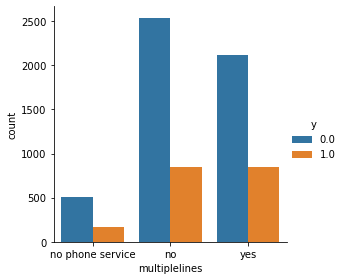

In [192]:
get_cat_vis(cat_list[0])

proportion of 1
fiber optic    0.418928
dsl            0.189591
no             0.074050
Name: internetservice, dtype: float64


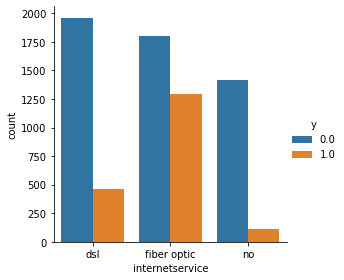

In [193]:
get_cat_vis(cat_list[1])

proportion of 1
no                     0.335231
yes                    0.300702
no internet service    0.074050
Name: streamingtv, dtype: float64


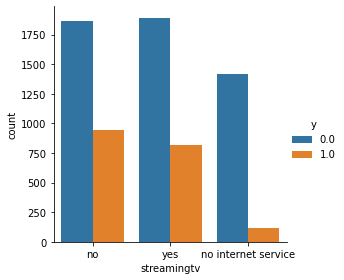

In [194]:
get_cat_vis(cat_list[2])

proportion of 1
month-to-month    0.427097
one year          0.112695
two year          0.028319
Name: contract, dtype: float64


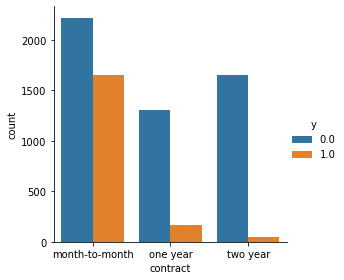

In [195]:
get_cat_vis(cat_list[3])

proportion of 1
electronic check             0.452854
mailed check                 0.191067
bank transfer (automatic)    0.167098
credit card (automatic)      0.152431
Name: paymentmethod, dtype: float64


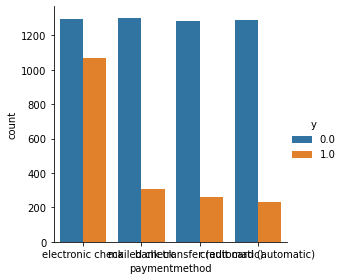

In [196]:
get_cat_vis(cat_list[4])

# report data types

In [198]:
numerical_cols, other_cols = get_numerical_mask(data)
# numerical_cols.remove('y')
print(numerical_cols)

num_df = pd.DataFrame(numerical_cols)
other_df = pd.DataFrame(other_cols)

['gender_male', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingmovies', 'paperlessbilling', 'monthlycharges', 'totalcharges', 'y']


#### concatenate

In [199]:
report_df = pd.concat([num_df,other_df], ignore_index=True, axis=1)
report_df.columns = ['numerical_cols', 'non_numerical_cols']

# Checking  for possible anomalies in the database
Here we check for some possible anomalies. If there was one, we should look for solutions such as: contact the team responsible for data engineering or anyone who has a good understanding of the provided data, search for flaws in the data pipeline, or at least document for those anomalies.

Check if there is any oddity in data.

In [200]:
data.loc[:, ].describe()

,gender_male,seniorcitizen,partner,dependents,tenure,phoneservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingmovies,paperlessbilling,monthlycharges,totalcharges,y
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,5517.000000,5517.000000,5517.000000,5517.000000,5517.000000,7043.000000,7043.000000,7032.000000,7043.000000
mean,0.504756,0.162147,0.483033,0.299588,32.371149,0.903166,0.365960,0.440276,0.439007,0.370491,0.495197,0.592219,64.761692,2283.300441,0.265370
std,0.500013,0.368612,0.499748,0.458110,24.559481,0.295752,0.481742,0.496465,0.496311,0.482980,0.500022,0.491457,30.090047,2266.771362,0.441561
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.500000,401.450000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,70.350000,1397.475000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.850000,3794.737500,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,1.000000


# boxplots
This is useful to check for outliers, which will be handled later. Also, some values might be misleading, requiring a preimputation step. For instance: hours per week shouldn't surpass 140. Age shouldn't go well beyond 90.

In [201]:
numerical_cols, other_cols = get_numerical_mask(data)

In [202]:
print(numerical_cols)

['gender_male', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingmovies', 'paperlessbilling', 'monthlycharges', 'totalcharges', 'y']


In [203]:
partition = int(len(numerical_cols)/5)

In [204]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[:partition*1]], '01')

In [205]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[partition*1:partition*2]], '02')

In [206]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[partition*2:partition*3]], '02')

In [207]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[partition*3:partition*4]], '02')

In [208]:
if not sandbox_mode:
    build_boxplots(data[numerical_cols[partition*4:partition*5]], '02')

# save data

In [184]:
data.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,y
id,,,,,,,,,,,,,,,,,,,,
7590-vhveg,female,0,yes,no,1,no,no phone service,dsl,no,yes,no,no,no,no,month-to-month,yes,electronic check,29.85,29.85,no
5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,no,yes,no,no,no,one year,no,mailed check,56.95,1889.5,no
3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,yes,no,no,no,no,month-to-month,yes,mailed check,53.85,108.15,yes
7795-cfocw,male,0,no,no,45,no,no phone service,dsl,yes,no,yes,yes,no,no,one year,no,bank transfer (automatic),42.30,1840.75,no
9237-hqitu,female,0,no,no,2,yes,no,fiber optic,no,no,no,no,no,no,month-to-month,yes,electronic check,70.70,151.65,yes


In [209]:
data.to_csv(os.path.join(outputs, 'data.csv'))